# XGBoost con Class Weights

**Obiettivo:** Classificazione binaria IncidentGrade con pesi per bilanciare le classi

**Dataset:** Processed v3

**Differenza da v2:** Usa `sample_weight` per bilanciare le classi durante il training

**Pipeline:**
1. Caricamento dati processed_v3
2. Calcolo sample weights basati su class distribution
3. Training XGBoost con sample_weight
4. Valutazione e confronto

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    roc_curve,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.utils.class_weight import compute_sample_weight
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

print("Librerie importate con successo!")

Librerie importate con successo!


## 2. Caricamento Dati

In [2]:
print("Caricamento dataset processed_v3...\n")

X_train = pd.read_csv('../data/processed_v3_balanced/X_train.csv')
X_test = pd.read_csv('../data/processed_v3_balanced/X_test.csv')
y_train = pd.read_csv('../data/processed_v3_balanced/y_train.csv')['BinaryIncidentGrade']
y_test = pd.read_csv('../data/processed_v3_balanced/y_test.csv')['BinaryIncidentGrade']

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nDistribuzione y_train:")
print(y_train.value_counts())
print(f"\nPercentuali:")
print(y_train.value_counts(normalize=True))

Caricamento dataset processed_v3...

X_train: (348918, 43)
X_test: (149537, 43)

Distribuzione y_train:
BinaryIncidentGrade
0    247302
1    101616
Name: count, dtype: int64

Percentuali:
BinaryIncidentGrade
0    0.708768
1    0.291232
Name: proportion, dtype: float64


## 3. Calcolo Sample Weights

In [3]:
# Calcola sample weights per bilanciare le classi
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Sample weights calcolati:")
print(f"  Min weight: {sample_weights.min():.4f}")
print(f"  Max weight: {sample_weights.max():.4f}")
print(f"  Mean weight: {sample_weights.mean():.4f}")
print(f"\nPeso medio per classe:")
for class_label in [0, 1]:
    mask = y_train == class_label
    print(f"  Classe {class_label}: {sample_weights[mask].mean():.4f}")

Sample weights calcolati:
  Min weight: 0.7054
  Max weight: 1.7168
  Mean weight: 1.0000

Peso medio per classe:
  Classe 0: 0.7054
  Classe 1: 1.7168


## 4. Training XGBoost con Sample Weights

In [4]:
print("Training XGBoost con sample weights...\n")

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=True
)

print("\nTraining completato!")

Training XGBoost con sample weights...

[0]	validation_0-auc:0.88532
[1]	validation_0-auc:0.88587
[2]	validation_0-auc:0.90428
[3]	validation_0-auc:0.90925
[4]	validation_0-auc:0.90946
[5]	validation_0-auc:0.91183
[6]	validation_0-auc:0.91236
[7]	validation_0-auc:0.91340
[8]	validation_0-auc:0.91412
[9]	validation_0-auc:0.91462
[10]	validation_0-auc:0.91464
[11]	validation_0-auc:0.91492
[12]	validation_0-auc:0.91572
[13]	validation_0-auc:0.91608
[14]	validation_0-auc:0.91621
[15]	validation_0-auc:0.91655
[16]	validation_0-auc:0.91667
[17]	validation_0-auc:0.91697
[18]	validation_0-auc:0.91702
[19]	validation_0-auc:0.91704
[20]	validation_0-auc:0.91751
[21]	validation_0-auc:0.91750
[22]	validation_0-auc:0.91770
[23]	validation_0-auc:0.91802
[24]	validation_0-auc:0.91830
[25]	validation_0-auc:0.91837
[26]	validation_0-auc:0.91848
[27]	validation_0-auc:0.91865
[28]	validation_0-auc:0.91874
[29]	validation_0-auc:0.91882
[30]	validation_0-auc:0.91903
[31]	validation_0-auc:0.91906
[32]	valid

## 5. Valutazione Performance

In [5]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("=" * 70)
print("PERFORMANCE TEST SET - CON CLASS WEIGHTS")
print("=" * 70)

print("\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=['Non-TP (0)', 'TruePositive (1)'],
    digits=4
))

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nACCURACY:          {accuracy:.4f}")
print(f"PRECISION:         {precision:.4f}")
print(f"RECALL:            {recall:.4f}")
print(f"F1-SCORE:          {f1:.4f}")
print(f"ROC AUC:           {roc_auc:.4f} ⭐")

PERFORMANCE TEST SET - CON CLASS WEIGHTS

Classification Report:
                  precision    recall  f1-score   support

      Non-TP (0)     0.9074    0.9155    0.9114    105987
TruePositive (1)     0.7897    0.7728    0.7812     43550

        accuracy                         0.8739    149537
       macro avg     0.8486    0.8441    0.8463    149537
    weighted avg     0.8732    0.8739    0.8735    149537


ACCURACY:          0.8739
PRECISION:         0.7897
RECALL:            0.7728
F1-SCORE:          0.7812
ROC AUC:           0.9317 ⭐


## 6. Confusion Matrix

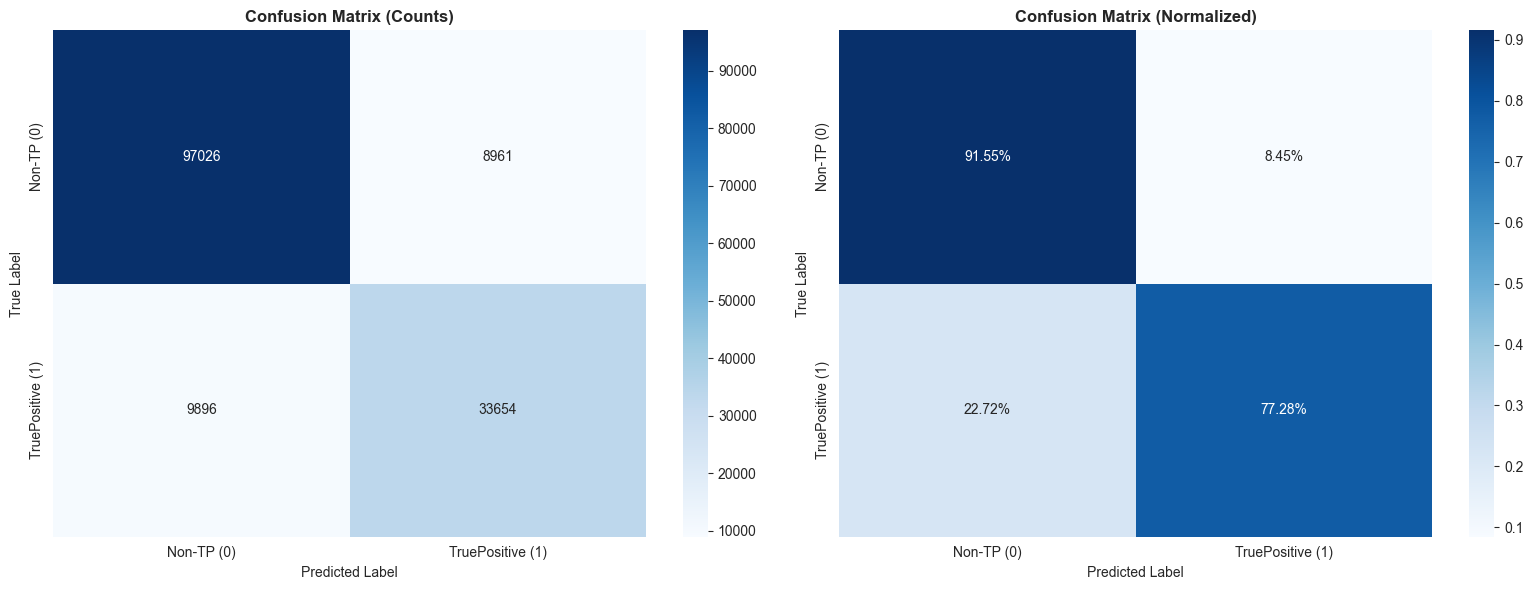

In [6]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-TP (0)', 'TruePositive (1)'],
            yticklabels=['Non-TP (0)', 'TruePositive (1)'],
            ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Non-TP (0)', 'TruePositive (1)'],
            yticklabels=['Non-TP (0)', 'TruePositive (1)'],
            ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 7. ROC Curve

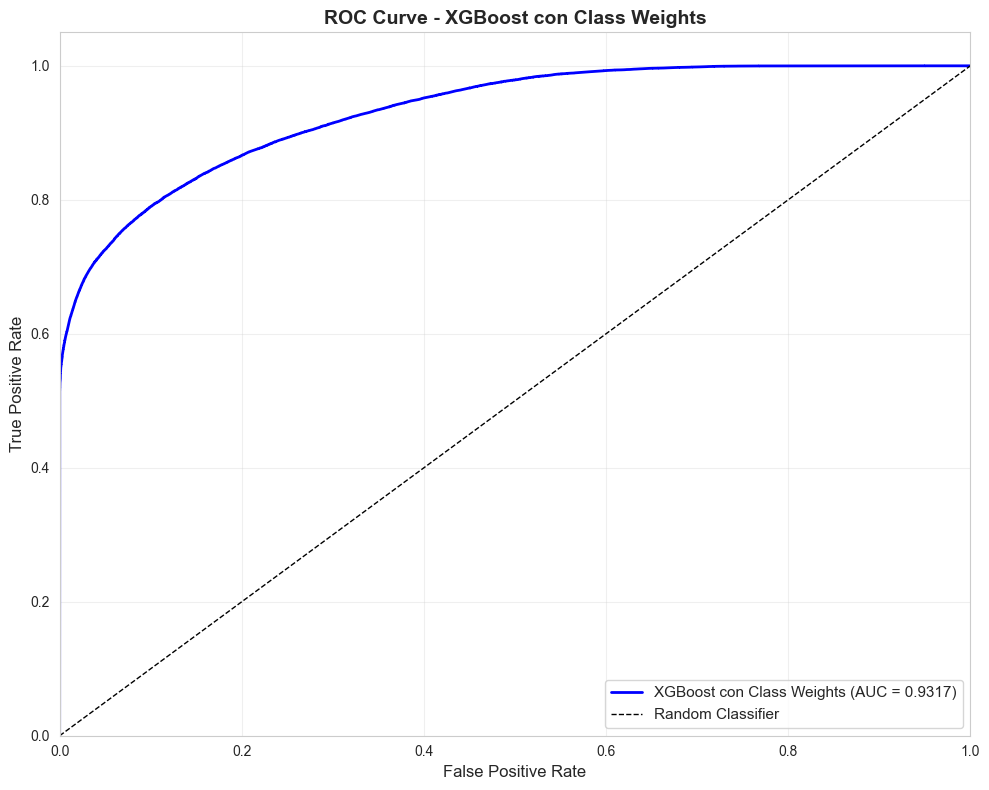


📊 ROC AUC Score: 0.9317


In [7]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2,
         label=f'XGBoost con Class Weights (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - XGBoost con Class Weights', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 ROC AUC Score: {roc_auc:.4f}")

## 8. Feature Importance

In [8]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Features più importanti:")
print(feature_importance.head(20).to_string(index=False))

Top 20 Features più importanti:
                      Feature  Importance
       ResourceType_freq_mean    0.344621
      ActionGrouped_freq_mean    0.326543
     ActionGranular_freq_mean    0.184715
             SmoothedRisk_avg    0.033950
                    T1078_sum    0.029293
              GeoLoc_freq_avg    0.009657
     EvidenceRole_Related_sum    0.007947
        LastVerdict_freq_mean    0.006467
              Roles_freq_mean    0.005650
       ThreatFamily_freq_mean    0.005335
         EntityType_freq_mean    0.004634
           Category_freq_mean    0.004061
   SuspicionLevel_Missing_sum    0.003889
                    T1046_sum    0.002406
             Duration_seconds    0.002333
                    NumAlerts    0.001927
                 NumEvidences    0.001786
SuspicionLevel_Suspicious_sum    0.001667
                    T1106_sum    0.001650
                    T1110_sum    0.001513


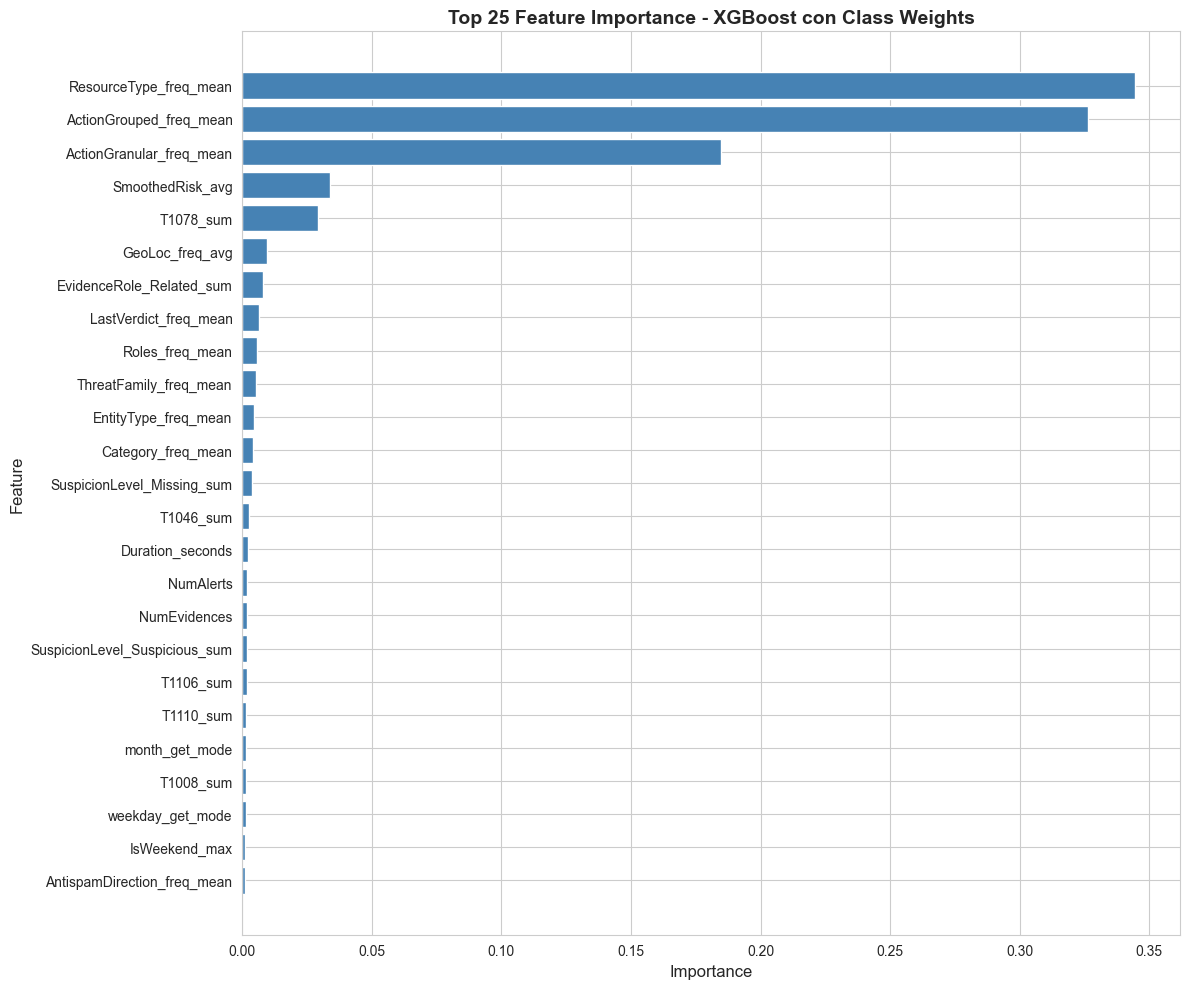

In [9]:
plt.figure(figsize=(12, 10))
top_n = 25
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['Importance'], color='steelblue')
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Feature Importance - XGBoost con Class Weights', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Summary

**Modello:** XGBoost Binary Classifier con Sample Weights

**Differenza chiave:** 
- v2: usa `scale_pos_weight` (parametro del modello)
- Questo: usa `sample_weight` nel fit (più flessibile)

**Vantaggi sample_weight:**
- Peso personalizzabile per ogni sample
- Bilanciamento automatico con `compute_sample_weight`
- Migliore controllo su recall/precision trade-off

**Metriche da confrontare con v2:**
- ROC AUC (primary)
- Recall per classe 1 (TruePositive)
- F1-Score bilanciato

In [ ]:
# Calcola metriche per entrambe le classi
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

# Salva metriche in JSON
metrics = {
    "model_name": "XGBoost_ClassWeights",
    "timestamp": datetime.now().isoformat(),
    "dataset_version": "processed_v3",
    "class_balancing": "Sample weights (compute_sample_weight 'balanced')",
    "test_accuracy": float(accuracy_score(y_test, y_pred)),
    "test_precision": float(precision_1),
    "test_recall": float(recall_1),
    "test_f1_score": float(f1_1),
    "test_roc_auc": float(roc_auc),
    "n_features": X_train.shape[1],
    "n_train_samples": len(X_train),
    "n_test_samples": len(X_test),
    "class_distribution_train": {
        "class_0": int((y_train == 0).sum()),
        "class_1": int((y_train == 1).sum())
    },
    "per_class_metrics": {
        "class_0_non_tp": {
            "precision": float(precision_0),
            "recall": float(recall_0),
            "f1_score": float(f1_0)
        },
        "class_1_tp": {
            "precision": float(precision_1),
            "recall": float(recall_1),
            "f1_score": float(f1_1)
        }
    },
    "confusion_matrix": {
        "true_negatives": int(cm[0, 0]),
        "false_positives": int(cm[0, 1]),
        "false_negatives": int(cm[1, 0]),
        "true_positives": int(cm[1, 1])
    },
    "hyperparameters": {
        "objective": "binary:logistic",
        "max_depth": 6,
        "learning_rate": 0.1,
        "n_estimators": 200,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "use_sample_weight": True
    },
    "top_10_features": feature_importance.head(10).to_dict('records')
}

with open(f'{model_dir}/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Metriche salvate: {model_dir}/metrics.json")

print(f"\n{'='*60}")
print("RIEPILOGO SALVATAGGIO")
print(f"{'='*60}")
print(f"Directory: {model_dir}")
print(f"  - model.json")
print(f"  - feature_importance.csv")
print(f"  - metrics.json")
print(f"{'='*60}")

In [ ]:
import os
import json
from datetime import datetime

# Crea directory per il modello
model_dir = '../models/xgboost_classweights'
os.makedirs(model_dir, exist_ok=True)

# Salva modello XGBoost
model.save_model(f'{model_dir}/model.json')
print(f"✅ Modello salvato: {model_dir}/model.json")

# Salva feature importance
feature_importance.to_csv(f'{model_dir}/feature_importance.csv', index=False)
print(f"✅ Feature importance salvato: {model_dir}/feature_importance.csv")

## 9. Salvataggio Modello e Metriche